# Overview
ClinVar is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

Conflicting classifications are when any *two* of the following three categories are present for *one* variant

Likely Benign or Benign

VUS (uncertain significance) 

Likely Pathogenic or Pathogenic

Otherwise the classification is labelled as in agreement.


# Objective 

To predict laboratory classifications agreements/disagreements (target variable) using measured (predicted) feature variables. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.

Conflicting classification has been assigned to the CLASS column of the data. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df= pd.read_csv('clinvar_conflicting.csv', low_memory=False)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


# Exploratory Data Analysis

In [3]:
print('Number of features:',df.columns.size)
print('Number of observations:', df.index.size)

Number of features: 46
Number of observations: 65188


The wrangled dataframe contains 46 variables and 65188 observations. This means that there are 45 feature variables and 1 target variable (the classification binary value). 

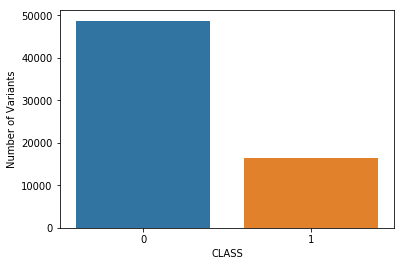

In [4]:
# visualize distribution of binary value CLASS
cnt= sns.countplot(x='CLASS', data=df)
cnt.set(xlabel='CLASS', ylabel= 'Number of Variants')
plt.savefig('split.png')
plt.show()

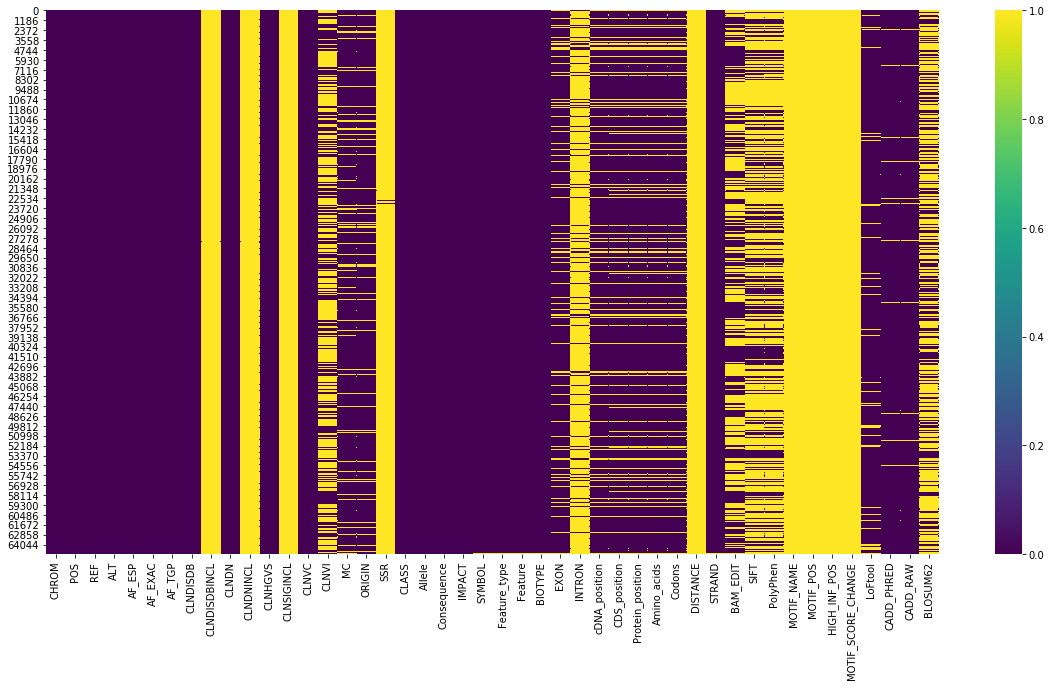

In [5]:
# visually examine null values
fig = plt.figure(figsize = (20,10))
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True)
plt.savefig('null.png')
plt.show()

Above are two plots that visualize the data. The first shows a count plof of the clinical lab classifications. From this I can see that there are 3 times as many clinical agreements than there are conflicts. This observation suggests that the anomalies lie within the conflicting cases. However, valuable insight can be drawn from both CLASS cases that shed light solely on the conflicting case so the analysis will proceed to study both cases in tandum. 

The second plot highlights the amount of null values that each feature contains. These features will provide no value to the analysis of the data, and will be dropped.

## Data cleaning and processing

The data cleaning and processing will involve 2 steps 

1. Filter out of the dataframe all features with less than 50000 non-null entries
2. Drop features with > (10% of number of observations) unique values

The ultimate goal of this notebook is to discover patterns and relationships between features and classifications. I will therefore drop those features which contain several null values or contain several unique values (which would inhibit pattern findings, potentially and likely in the form of overfitting).

In [6]:
# define function to filter a dataframe's columns based on how many non-null objects they have

def filter_df(data,num_of_entries):    
    list= []
    for x in data.columns:
        if data[x].count() >= num_of_entries:
            list.append(x)
    return data[list]

In [7]:
fildf= filter_df(df,50000)
fildf=fildf.dropna()

# establish a list of cutdowns to be made on dataframe fildf where each feature has < 1000 unique elements
cutdowns = []
for i in fildf.columns.values:
    if fildf[i].nunique() < 4000:
        cutdowns.append(i)
df2=fildf[cutdowns]

In [8]:
#df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44572 entries, 0 to 65171
Data columns (total 22 columns):
CHROM           44572 non-null object
REF             44572 non-null object
ALT             44572 non-null object
AF_ESP          44572 non-null float64
AF_EXAC         44572 non-null float64
AF_TGP          44572 non-null float64
CLNVC           44572 non-null object
MC              44572 non-null object
ORIGIN          44572 non-null float64
CLASS           44572 non-null int64
Allele          44572 non-null object
Consequence     44572 non-null object
IMPACT          44572 non-null object
SYMBOL          44572 non-null object
Feature_type    44572 non-null object
Feature         44572 non-null object
BIOTYPE         44572 non-null object
EXON            44572 non-null object
Amino_acids     44572 non-null object
Codons          44572 non-null object
STRAND          44572 non-null float64
LoFtool         44572 non-null float64
dtypes: float64(6), int64(1), object(15)
memory us

The result of our data cleaning and processing is found in the (surpressed) info call. I filtered the original dataframe by features with less than 4000 unique values and greater than 50000 non-null entries. The final product of this process is a full dataframe with 21 feature variables and 1 target variable (CLASS), each with 44572 non-null entries. This will make for an abundance of data to work with to discover patterns and relationships. 

## Data Visualization 

Questions: 

1. Which feature variables have a visual correlation to the target variable CLASS?
2. How do the values of feature variables relate to the target variable in terms of counts and percentages?
3. Are there any more feature variables that should be cut from the current dataframe in preperation of applying ML algorithms?

I will move onto visually inspecting the feature variables as they relate to the target variable to see if I can determine outstanding relationships. To do this I will first need to crosstabulate the data i.e. how many times each value of the features occurs in which classification (0,1). I will take the top *x* results and visualize their cross-tabulation with the classifications by constructing three heatmaps as described below:

1. A number of occurrences count cross-tabulation that shows how many times a specific value occurred in which classification
2. A percentage-of-total cross-tabulation, which will show the *percentage* of the *total number* of values each value has in the cross tabulation
3. A split percentage cross-tabulation, which will show the percentage breakdown of classification between values (i.e. 40% classified as 1 and 60% classified as 0)

In [9]:
#general cross-tabulation function -> can tabulate any two features
def ctab(df,variable1, x, variable2, y):
    # a and b are dataframes containing top x,y most occuring values (sorted high->low) in the variables variable1,variable2
    a=df.groupby(variable1).size().to_frame('cnt').sort_values('cnt', ascending= False).iloc[:x]
    b=df.groupby(variable2).size().to_frame('cnt').sort_values('cnt', ascending= False).iloc[:y]
    
    # c will create a new dataframe filtered by intersecting a,b variable values
    
    c= df[df[variable1].isin(a.index.values) & df[variable2].isin(b.index.values)]
    
    # .isin accepts a list as an argument and will filter based upon what values are in that list
    # much like SQL IN clause
    # to get dataframes a and b into appropriate list forms we first call .index, which accessess the indices list of the 
    # dataframe variables values and then .values turns into a numpy array
    
    # crosstabulate the variables of interest
    return pd.crosstab(c[variable1],c[variable2])

In [10]:
# mapping function explictely constructed to look at feature variables vs target variable CLASS
def map(variable2, y, df=df2, variable1='CLASS',x=2):
    # incorporate ctab function
    crosstab= ctab(df, variable1, x, variable2, y)
    
    # construct and format subplots
    fig, ax= plt.subplots(2,2, figsize= (10,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=.3,hspace=.5)
    # hide axes of (1,1) subplot
    ax[-1, -1].axis('off')
    # standard countplot of crosstabulation
    sns.heatmap(crosstab, cmap='Blues', linewidth=.05, linecolor= 'black', ax= ax[0,0])
    ax[0,0].set_title('1. Number of Occurrences')

    # frequency of occurances compared to total number of entries per classification (0,1)
    zero_tot_div= df2[df2.CLASS==0][crosstab.columns.name].size
    one_tot_div= df2[df2.CLASS==1][crosstab.columns.name].size
    tot_div= crosstab.div([zero_tot_div, one_tot_div], axis=0)
    sns.heatmap(tot_div, cmap='Reds', linewidth=.05, linecolor= 'black', ax= ax[0,1])
    ax[0,1].set_title('2. Percentage of Total')

    # perentages of feature that split into classification 0 or 1
    divisor= np.sum(crosstab.values, axis=0)
    split_per= crosstab.div(divisor)
    sns.heatmap(split_per, cmap='Greens', linewidth=.05, linecolor= 'black', ax= ax[1,0])
    ax[1,0].set_title('3. Split Percentage')
    

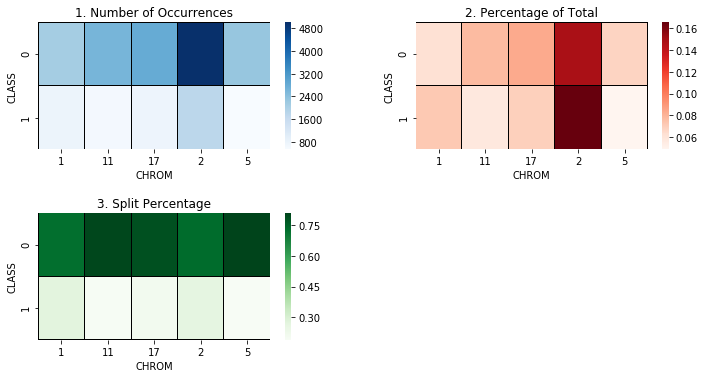

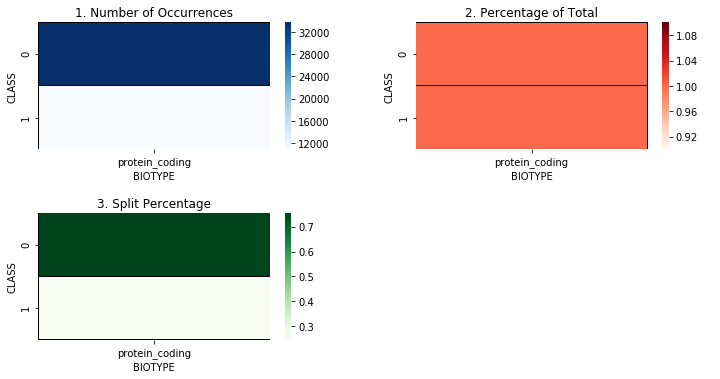

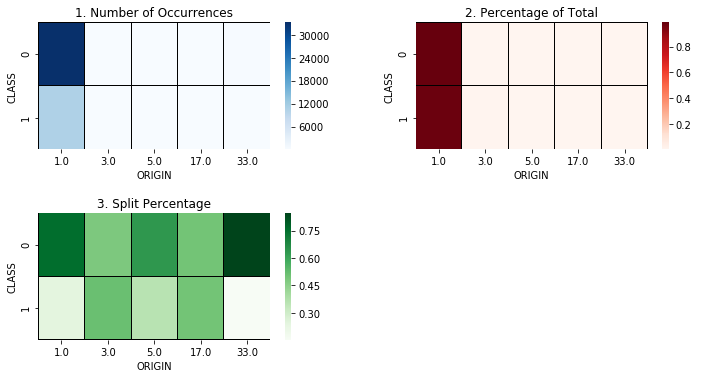

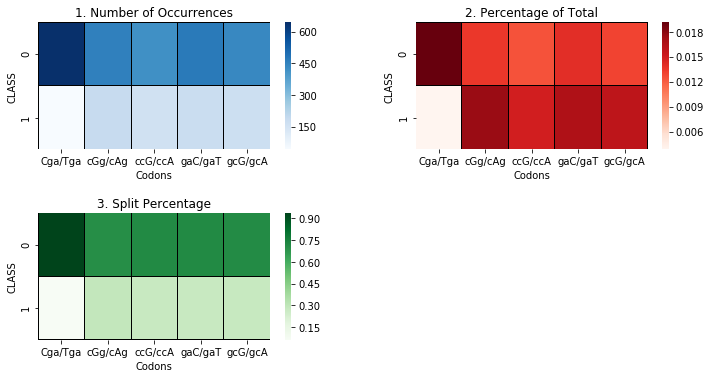

In [11]:
# take every feature in cleaned dataframe and visualize corresponding 3 heatmaps 
# this will inform our decision to drop any more features
for i in ['CHROM','BIOTYPE','ORIGIN','Codons'] :
  #  if i=='CLASS':
   #     continue
   # else:
        map(i,5) 
        plt.savefig(i+'.png')
# majority of feature heatmaps suppressed for computation purposes- the 4 feature variables heatmapped by this code are
# representative of the rest

In [347]:
df3= df2.drop(columns=['SYMBOL','BIOTYPE','Feature_type','ORIGIN','CLNVC','Feature','EXON', 'Amino_acids','Codons','LoFtool'], axis=1)\
.reset_index()
df3= df3.drop(columns='index')

The result of the visualization revealed an interesting insight. Although the features 'BIOTYPE' and 'Feature_type' made it through the data cleaning and processing stage, the visualization highlighted the fact that they only have 1 unique value each. Including these features in the machine learning model will be redundent and offer no substantial information. Therefore we will drop them. Furthermore, the feature variables 'ORIGIN' and 'CLNVC' display a similar phenonmneon. Although they both have more than one unique value, a bulk of total percentage lies in only one value (resemebles the problem in the previous 2 variables). On the opposite side of the spectrum, the feature variables 'SYMBOL', 'Feature','EXON', 'Amino_acids','Codons', and 'LoFtool' have far too many unique values and could lead a ML model to overfit the data (or have a long computation time). Therefore we cut all of the feature variables. The remaining 11 feature variables look promising on a visual level in terms of target variable correlation. The next step of my analysis will be a feature chi-square selection to determine correlations between the feature variables and the target variable. For the machine learning model to be truly optimized, there must be some correlation between the model's feature variables and the target variable.

## Pearson Chi-Squared Test

The Chi-Squared test is a statistical hypothesis test observed frequencies vs expected frequencies under the following null hypothesis.

Null Hypothesis (H0)- the observed frequencies match expected frequencies i.e. the two variables are *independent*

Alternative Hypothesis- the observed frequencies do not match the expected frequencies i.e. the two variables have some dependency

In [14]:
from scipy.stats import chi2, chi2_contingency

In [15]:
# Construct function that will run chi-square test for all feature variables to test for categorical dependence significance.
for i in df3.columns:
    prob=.99
    if i=='CLASS':
        continue
    else: 
        print(i +' feature is:')
        table= ctab(df3,'CLASS',2,i,df3[i].size)
        stat, p, dof, expected = chi2_contingency(table)
        critical= chi2.ppf(prob,dof)
        print('P-value:',p)
        if abs(stat) >= critical:
            print('Dependent: reject H0 \n')
        else:
            print('Independent: (fail to reject H0) \n')

CHROM feature is:
P-value: 9.858021132759068e-49
Dependent: reject H0 

REF feature is:
P-value: 0.008959911563326062
Dependent: reject H0 

ALT feature is:
P-value: 0.07665218907151529
Independent: (fail to reject H0) 

AF_ESP feature is:
P-value: 5.395652117800568e-113
Dependent: reject H0 

AF_EXAC feature is:
P-value: 3.2598428254959263e-99
Dependent: reject H0 

AF_TGP feature is:
P-value: 2.1876108405572567e-200
Dependent: reject H0 

MC feature is:
P-value: 8.177537721972858e-91
Dependent: reject H0 

Allele feature is:
P-value: 3.8917089655568735e-09
Dependent: reject H0 

Consequence feature is:
P-value: 2.9253751555872266e-104
Dependent: reject H0 

IMPACT feature is:
P-value: 8.964615863520214e-112
Dependent: reject H0 

STRAND feature is:
P-value: 1.313143276839513e-20
Dependent: reject H0 



The result of my Chi-squared test determined only one variable to be independent of the binary CLASS variable- ALT. The ALT feature failed the Chi-Squared significance test and will therefore be dropped from the dataframe in preperation to apply machine learning algorithms. This means that there are 11 remaining feature variables to predict the target CLASS variable. Before I begin to apply ML algorithms, however, I will preprocess the categorical feature variables through feature engineering to ensure optimum model performance

## Feature Engineering

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning and I will be using 3 methods to preprocess my categorical data.

1. One hot encoding
2. Label Encoder
3. Feature Hashing

The three feature-processed dataframes will all have several ML alogorithms applied to them. In this sense, I can observe the most successful feature preprocessing method. 

In [95]:
target= df3.CLASS
df4= df3.drop(['CLASS','ALT'], axis=1)
df4.nunique()

CHROM            23
REF             273
AF_ESP         1892
AF_EXAC        3888
AF_TGP         1454
MC               64
Allele           96
Consequence      20
IMPACT            3
STRAND            2
dtype: int64

### One Hot Encoding

By the nunique call above, I can see that there are still thousands of unique variables in the 'AF' feature variables. If I were to one hot encode these three feature variables, the computation time of it alone (let alone applying ML algorithms) would be too great for this analysis. In the visualization phase, I notice that these feature variables consisted of 1 unique value 50% of the time. Therefore, I will implement a one-vs-rest encoding scheme to process these specific feature variables. 

In [96]:
# Use one hot encoding for all variables except the 3 AF features. These will take on a 1 vs rest encoding scheme (too many
# unique values per feature)
afdict={}
af= ['AF_ESP','AF_EXAC','AF_TGP']
for i in af:
    af0_bool= np.array(df3[i]==0)
    afx_bool= ~af0_bool
    afdict[i+'_0']=af0_bool
    afdict[i+'_x']=afx_bool
df_af= pd.DataFrame(afdict, dtype=int)
df5= pd.get_dummies(df4.drop(af, axis=1))
df_ohe= pd.concat([df5,df_af], axis=1)

### Label Encoder

In [97]:
from sklearn.preprocessing import LabelEncoder
# .apply applies the LabelEncoder.fit_transform function to all columns of dataframe
df_le=df4.apply(LabelEncoder().fit_transform)

### Feature Hashing

In [170]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=10,input_type = 'string')

In [346]:
# feature hashing cannot resolve dtypes of type float -> these are parsed seperately and label encoded
df_fhaf= df4[['AF_ESP','AF_EXAC', 'AF_TGP','STRAND']].apply(LabelEncoder().fit_transform)
df_fhx= df4.drop(df_fhaf.columns.values, axis=1)
dfs=[]
for i in df_fhx.columns.values:
    hashed= fh.fit_transform(df_fhx[i])
    hashed1=hashed.toarray()
    hashdf=pd.DataFrame(hashed1)
    kv={}
    for j in hashdf.columns.values:
        kv[j]= i+str(j+1)
    hashdf.rename(columns=kv, inplace=True)
    dfs.append(hashdf)
df_fhy=pd.concat(dfs, axis=1)
df_fh= pd.concat([df_fhy,df_fhaf], axis=1)

## ML Algorithms

The Machine Learning algorithms I am implementing are as follows: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and Support Vector Machine.

The target data is heavily skewed towards the agreement classification wih a ratio of about 3 agreements to every 1 disagreement. This naturally means that there will be more data for the models to test and train on in the agreement decision. Predictions for the disagreement classification will likely not have the same success as the agreement classification. Therefore I will be using the following metric to gauge model performance:

1. Accuracy- ratio of correctly predicted observation to the total observations
2. Precision- number of true positives divided by the number of true positives plus the number of false positives
3. Recall (Sensitivity) - number of true positives divided by the number of true positives plus the number of false negatives
4. F1 score- harmonic mean of precision and recall

By using *all* of the above metrics I can avoid classic model misinterpretations derived from observing just a single metric. All scores will be considered in terms of performance, with a greater emphasis on the f1 score as it considers both the precision and recall in its score. 

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
Xohe_train, Xohe_test, yohe_train, yohe_test = train_test_split(df_ohe.values, target, test_size = 0.40)
Xle_train, Xle_test, yle_train, yle_test = train_test_split(df_le.values, target, test_size = 0.40)
Xfh_train, Xfh_test, yfh_train, yfh_test = train_test_split(df_fh.values, target, test_size = 0.40)

In [313]:
# dataframes are df_ohe (one hot encoded), df_le (label encoded), df_fh (feature hashed)
def model(df, clf, test_size=.4):
    X_train, X_test, y_train, y_test = train_test_split(df.values, target, test_size = test_size)
    clf.fit(X_train, y_train)
    pred= clf.predict(X_test)
    print( "Classification Report :\n ", classification_report(y_test, pred))
    print('accuracy score:', accuracy_score(y_test,pred),'\n')

### Logisitc Regression

In [102]:
lr = LogisticRegression()

In [316]:
print('Logistic Regression (one hot encoded) \n')
model(df_ohe, lr)

Logistic Regression (one hot encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.75      1.00      0.86     13334
          1       0.75      0.00      0.00      4495

avg / total       0.75      0.75      0.64     17829

accuracy score: 0.7479948398676314 



In [315]:
print('Logistic Regression (label encoded) \n')
model(df_le, lr)

Logistic Regression (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.76      1.00      0.86     13518
          1       0.00      0.00      0.00      4311

avg / total       0.57      0.76      0.65     17829

accuracy score: 0.7576420438611251 



In [317]:
print('Logistic Regression (feature hashed) \n')
model(df_fh, lr)

Logistic Regression (feature hashed) 

Classification Report :
               precision    recall  f1-score   support

          0       0.76      1.00      0.86     13501
          1       0.17      0.00      0.00      4328

avg / total       0.61      0.76      0.65     17829

accuracy score: 0.7563520107689718 



The accuracy for all 3 preprocessed dataframes is fairly consistent around 75%. This is already a decent percentage. However, the recall and f1 score for the binary classification '1' is 0. This points towards an overall poor performing model and I will not try to optimize it any further. 

### Decision Tree

In [106]:
dt = DecisionTreeClassifier()

In [230]:
print('Decision Tree (one hot encoded) \n')
model(df_ohe, dt)

Decision Tree (one hot encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.77      0.91      0.84     13476
          1       0.37      0.16      0.22      4353

avg / total       0.67      0.73      0.68     17829

accuracy score: 0.7279151943462897


In [328]:
print('Decision Tree (label encoded) \n')
model(df_le, dt)

Decision Tree (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.80      0.85      0.82     13469
          1       0.41      0.33      0.36      4360

avg / total       0.70      0.72      0.71     17829

accuracy score: 0.7204554377699254 



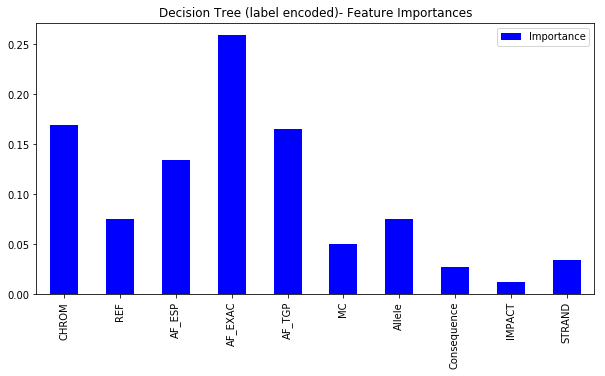

In [329]:
feature_imp = {}
for i in zip(df_le.columns, dt.feature_importances_):
    feature_imp[i[0]] = i[1]
df6 = pd.DataFrame(feature_imp, index = range(1)).T
df6.rename(columns={0: "Importance"}, inplace = True)
df6.plot(kind='bar',figsize = (10, 5), color= 'blue')
plt.title('Decision Tree (label encoded)- Feature Importances')
plt.savefig('dectree_fi_le.png')
plt.show()

In [330]:
print('Decision Tree (feature hashed) \n')
model(df_fh, dt)

Decision Tree (feature hashed) 

Classification Report :
               precision    recall  f1-score   support

          0       0.80      0.85      0.83     13504
          1       0.42      0.33      0.37      4325

avg / total       0.71      0.73      0.71     17829

accuracy score: 0.7264008076728925 



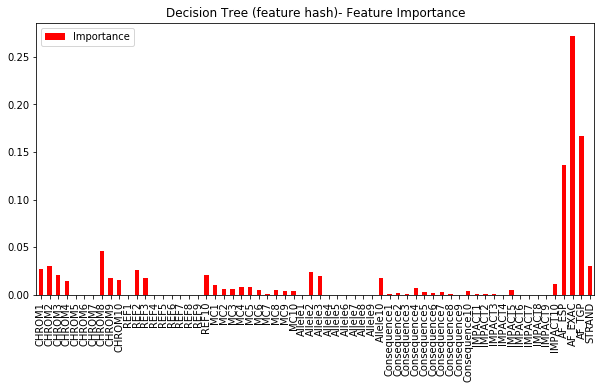

In [331]:
feature_imp4 = {}
for i in zip(df_fh.columns, dt.feature_importances_):
    feature_imp4[i[0]] = i[1]
df11 = pd.DataFrame(feature_imp4, index = range(1)).T
df11.rename(columns={0: "Importance"}, inplace = True)
df11.plot(kind='bar',figsize = (10, 5), color='red')
plt.title('Decision Tree (feature hash)- Feature Importance')
plt.savefig('dectree_fi_fh.png')
plt.show()

While the Decision Tree algorithm showed a drop in overall accuracy, the recall and f1 score improved dramatically. The label encoded data and the feature hashed data seemed to be consistently performing the best in the applied algorithms.

### Random Forest

In [111]:
rf = RandomForestClassifier()

In [241]:
print('Random Forest (one hot encoded) \n')
model(df_ohe, rf)

Random Forest (one hot encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.77      0.90      0.83     13411
          1       0.39      0.19      0.26      4418

avg / total       0.68      0.72      0.69     17829

accuracy score: 0.7248864209994952


In [320]:
print('Random Forest (label encoded) \n')
model(df_le, rf)

Random Forest (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.79      0.90      0.84     13477
          1       0.45      0.27      0.34      4352

avg / total       0.71      0.74      0.72     17829

accuracy score: 0.7430590610802625 



In [247]:
print('Random Forest (feature hashed) \n')
model(df_fh, rf)

Random Forest (feature hashed) 

Classification Report :
               precision    recall  f1-score   support

          0       0.79      0.90      0.84     13411
          1       0.45      0.25      0.33      4418

avg / total       0.70      0.74      0.71     17829

accuracy score: 0.7396937573616019


Again the accuracy of the model seems to be middle 70's, and the recall and f1 scores show an improvement from the Logistic Regression model. However, the Decision Tree still performs slightly better in the recall score in the disagreement classification. 

### Gradient Boosting

In [116]:
gra = GradientBoostingClassifier()

In [285]:
print('Gradient Boosting (one hot encoded) \n')
model(df_ohe, gra)

Gradient Boosting (one hot encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.76      1.00      0.86     13482
          1       0.42      0.00      0.00      4347

avg / total       0.67      0.76      0.65     17829

accuracy score: 0.7560154803971059


In [299]:
print('Gradient Boosting (label encoded) \n')
model(df_le, gra)

Gradient Boosting (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.78      0.95      0.86     13488
          1       0.54      0.19      0.28      4341

avg / total       0.72      0.76      0.72     17829

accuracy score: 0.7633630601828482


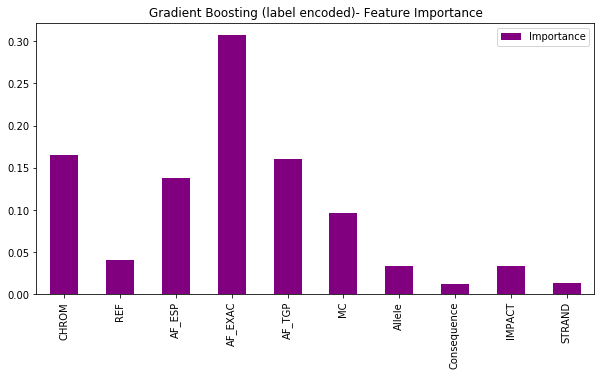

In [332]:
feature_imp5 = {}
for i in zip(df_le.columns, gra.feature_importances_):
    feature_imp5[i[0]] = i[1]
df12 = pd.DataFrame(feature_imp5, index = range(1)).T
df12.rename(columns={0: "Importance"}, inplace = True)
df12.plot(kind='bar',figsize = (10, 5), color='purple')
plt.title('Gradient Boosting (label encoded)- Feature Importance')
plt.savefig('gradboost_fi_le.png')
plt.show()

In [287]:
print('Gradient Boosting (feature hashed) \n')
model(df_fh, gra)

Gradient Boosting (feature hashed) 

Classification Report :
               precision    recall  f1-score   support

          0       0.78      0.96      0.86     13514
          1       0.57      0.17      0.26      4315

avg / total       0.73      0.77      0.72     17829

accuracy score: 0.7682988389702171


The gradient boosting algorithm shows the highest accuracies yet at nearly 77%. However, it has a relatively low recall score in the disagreement prediction.

### Support Vector Machine

Implementing the support vector machine algorithm proved to exceed computation time. Furthermore, the performance across all preprocessed data was worse than prior models and therefore is not shown or pursued in more depth.

The results of the applied machine learning algorithms show that the decision tree performs the overall best. In terms of preprocessed data, the label encoded and feature hashed seem to have the best performance. However, the simplicity of the label encoded data translates well into a low computation time and I will therefore be prioritizing this type of data during a computation-intensive procedure.

## Optimizing Decision Tree algorithm

For now, I have decided to optimize the Decision Tree algorithm paired with the label encoded data and featured hashed data to understand the extent to which these models performances can be pushed.

In [251]:
df8= df2.drop('CLASS',axis=1).apply(LabelEncoder().fit_transform)

In [252]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
best_min_samples_split=2
f1_scorer= make_scorer(f1_score)
# best min_sample_split=2 as predicted consistently several times
param_grid= {'max_depth':[11, 13, 15, 17, 19], 'min_samples_leaf': [1,2,3,4,5]}
grid=GridSearchCV(dt, param_grid, scoring=f1_scorer)
grid.fit(df8.values,target)
grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [333]:
dt_op = DecisionTreeClassifier(max_depth=15, min_samples_leaf= 5, min_samples_split=2)

In [335]:
print('Optimized Decision Tree (label encoded) \n')
model(df_le, dt_op)

Optimized Decision Tree (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.80      0.88      0.84     13482
          1       0.45      0.31      0.37      4347

avg / total       0.71      0.74      0.72     17829

accuracy score: 0.7405911716865781 



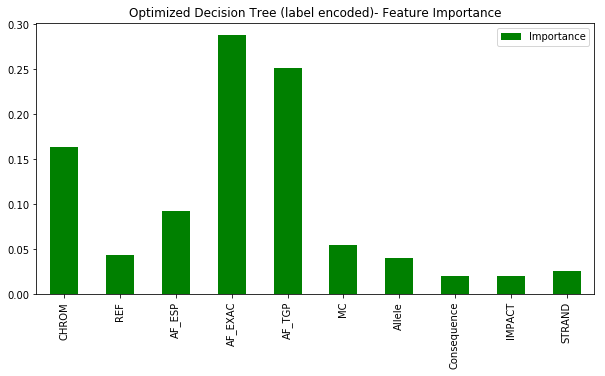

In [336]:
feature_imp2 = {}
for i in zip(df_le.columns, dt_op.feature_importances_):
    feature_imp2[i[0]] = i[1]
df9 = pd.DataFrame(feature_imp2, index = range(1)).T
df9.rename(columns={0: "Importance"}, inplace = True)
df9.plot(kind='bar',figsize = (10, 5), color='green')
plt.title('Optimized Decision Tree (label encoded)- Feature Importance')
plt.savefig('dectree_op_fi_le')
plt.show()

In [338]:
print('Optimized Decision Tree (feature hashed) \n')
model(df_fh, dt_op)

Optimized Decision Tree (feature hashed) 

Classification Report :
               precision    recall  f1-score   support

          0       0.80      0.90      0.85     13527
          1       0.47      0.30      0.37      4302

avg / total       0.72      0.75      0.73     17829

accuracy score: 0.7509114364238039 



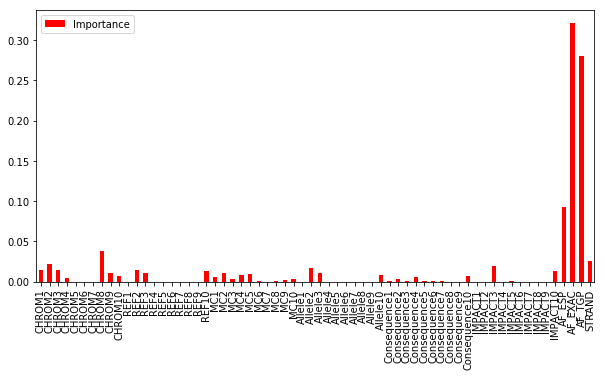

In [305]:
feature_imp3 = {}
for i in zip(df_fh.columns, dt_op.feature_importances_):
    feature_imp3[i[0]] = i[1]
df10 = pd.DataFrame(feature_imp3, index = range(1)).T
df10.rename(columns={0: "Importance"}, inplace = True)
df10.plot(kind='bar',figsize = (10, 5), color='red')
plt.show()

The result of the optimization process showed minimal improvement in terms of accuracy, recall score, and f1 score, but improvement nonetheless. Because the computation time was reasonable for all of these feature variables, I want to see if I can push the performance even higher by inclusion of previously dropped variables.

### Including More Variables

In [268]:
df_tot= df2.drop('CLASS', axis=1).apply(LabelEncoder().fit_transform)

In [340]:
print('Decision Tree w/ more feature variables (label encoded) \n')
model(df_tot, dt)

Decision Tree w/ more feature variables (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.81      0.80      0.80     13520
          1       0.39      0.41      0.40      4309

avg / total       0.71      0.71      0.71     17829

accuracy score: 0.7053115710359527 



In [339]:
print('Optimized Decision Tree w/ more feature variables (label encoded) \n')
model(df_tot, dt_op)

Optimized Decision Tree w/ more feature variables (label encoded) 

Classification Report :
               precision    recall  f1-score   support

          0       0.81      0.86      0.83     13462
          1       0.47      0.40      0.43      4367

avg / total       0.73      0.74      0.74     17829

accuracy score: 0.7439003870099277 



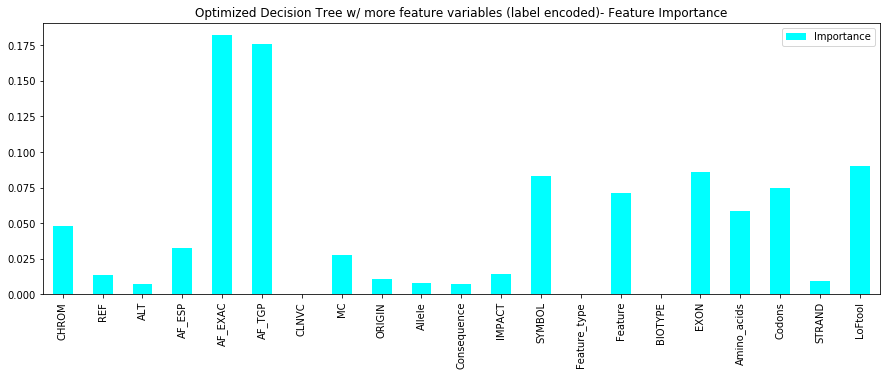

In [343]:
feature_imp3 = {}
for i in zip(df_tot.columns, dt_op.feature_importances_):
    feature_imp3[i[0]] = i[1]
df11 = pd.DataFrame(feature_imp3, index = range(1)).T
df11.rename(columns={0: "Importance"}, inplace = True)
df11.plot(kind='bar',figsize = (15, 5), color='cyan')
plt.title('Optimized Decision Tree w/ more feature variables (label encoded)- Feature Importance')
plt.savefig('dectree_var_op_le')
plt.show()

Including more feature variables noticeably increased computation time with only a slight improvement in the metrics. Furthermore the feature importances show a tendency towards overfitting in our model with the inclusion of more feature variables. 

## Interpretation

Both the label encoded data and feature hashed data perform similarly across all of my applied algorithms. However, the label encoded data seemed to have slightly less computation time when applying complex models such as the decision tree, random forest, and gradient boosting. Weighing all of the factors that go into model performance, the optimized decision tree when applied to the label encoded data performs the best when it comes to predicting classification agreements *and* disagreements. Meaning it produced the best accuracy score combined with the highest precision, recall, and f1 scores with the *lowest* computation time in both agreements and disagreements.

The result of the ML algorithm application revealed an interesting insight. The two feature variables ‘AF_EXAC’ and ‘AF_TGP’ consistently had the biggest impact on more than one model’s prediction. As defined in the dataset, these two feature variables are the allele frequencies from two of the three participating clinical labs. The interesting insight is that the third lab’s allele frequency observations did not have as much of an impact on our models’ predictive powers. This suggests that the two labs that contributed the most to the target binary variable classification agreement are ExAC and 1000 Genome Project (TGP). Extracting a greater and more explicit interpretation from this: the laboratory agreement hinged upon these two labs. If ExAC and TGP agreed on a genetic variants’ classification (due in part to their measured allele frequencies), the *overall* classification would be an agreement (CLASS=0), meaning that the third lab GO-ESP would also tend to agree on their classification. A further analysis would dive more deeply into the measured allele frequencies to determine their suggested importance on the outcome classification agreement/disagreement. Ultimately the analysis would test the hypothesis that the two labs ExAC and TGP defined allele frequencies that majorly impacted the agreements/disagreements across all three labs.